In [233]:
#Importamos librerías
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [234]:
inv = pd.read_csv("inventario_central_v2_limpio.csv")
trx = pd.read_csv("transacciones_logistica_final_unificado.csv")
fb  = pd.read_csv("feedback_clientes_limpio.csv")

In [235]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Feedback_ID                  4455 non-null   object 
 1   Transaccion_ID               4455 non-null   object 
 2   Rating_Producto              4455 non-null   int64  
 3   Rating_Logistica             4455 non-null   int64  
 4   Comentario_Texto             4455 non-null   object 
 5   Recomienda_Marca             4455 non-null   object 
 6   Ticket_Soporte_Abierto       4455 non-null   object 
 7   Edad_Cliente                 4455 non-null   int64  
 8   Satisfaccion_NPS             4455 non-null   float64
 9   Satisfaccion_NPS_norm        4455 non-null   float64
 10  Cantidad_Productos_Feedback  4455 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 383.0+ KB


In [236]:
# Función realizada por IA
def audit(df):
    return pd.DataFrame({
        "nulos_%": df.isna().mean() * 100,
        "tipo": df.dtypes
    })

  ### Unión estratégica

In [237]:
# Normalizar llaves
inv["SKU_ID"] = inv["SKU_ID"].astype(str).str.strip()
trx["SKU_ID"] = trx["SKU_ID"].astype(str).str.strip()
trx["Transaccion_ID"] = trx["Transaccion_ID"].astype(str).str.strip()
fb["Transaccion_ID"]  = fb["Transaccion_ID"].astype(str).str.strip()

print("Chequeo rápido de llaves")
print("SKUs únicos en trx:", trx["SKU_ID"].nunique())
print("SKUs únicos en inv:", inv["SKU_ID"].nunique())
print("Transacciones únicas en trx:", trx["Transaccion_ID"].nunique())
print("Transacciones únicas en fb:", fb["Transaccion_ID"].nunique())

Chequeo rápido de llaves
SKUs únicos en trx: 2886
SKUs únicos en inv: 2413
Transacciones únicas en trx: 9815
Transacciones únicas en fb: 3595


In [238]:
# Consolidar feedback a nivel Transaccion_ID (1 fila por transacción)
agg_map = {
    "Rating_Producto": "mean",
    "Rating_Logistica": "mean",
    "Satisfaccion_NPS": "mean",
    "Edad_Cliente": "mean",
}

# Ticket_Soporte_Abierto suele ser Sí/No -> booleano; agregación: any()
if "Ticket_Soporte_Abierto" in fb.columns:
    ticket = fb["Ticket_Soporte_Abierto"].astype(str).str.strip().str.lower()
    fb["_Ticket_Soporte_bool"] = ticket.isin(["si", "sí", "s", "yes", "true", "1"])
    agg_map["_Ticket_Soporte_bool"] = "any"

fb_agg = (
    fb.groupby("Transaccion_ID", as_index=False)
      .agg(agg_map)
)

if "_Ticket_Soporte_bool" in fb_agg.columns:
    fb_agg = fb_agg.rename(columns={"_Ticket_Soporte_bool": "Ticket_Soporte_Abierto"})

print("Feedback agregado")
print("Filas fb original:", len(fb))
print("Filas fb_agg (1 por Transaccion_ID):", len(fb_agg))

Feedback agregado
Filas fb original: 4455
Filas fb_agg (1 por Transaccion_ID): 3595


In [239]:
# Join TRX + FB (a nivel transacción)
# Nota: conservar transacciones sin feedback, cambie how="left".
trx_fb = trx.merge(
    fb_agg,
    on="Transaccion_ID",
    how="inner",
    validate="many_to_one"  # muchas transacciones -> 1 fila de feedback agregado
)

print("== Join trx + fb_agg ==")
print("Filas trx:", len(trx))
print("Filas trx_fb (inner):", len(trx_fb))
print("Transacciones perdidas por no tener feedback:",
      trx["Transaccion_ID"].nunique() - trx_fb["Transaccion_ID"].nunique())

== Join trx + fb_agg ==
Filas trx: 9815
Filas trx_fb (inner): 3525
Transacciones perdidas por no tener feedback: 6290


In [240]:
# Dilema SKU Fantasma: decidir estrategia de unión con inventario
# Estrategia: LEFT join desde trx_fb hacia inv
# - Mantiene ventas aunque no exista SKU en inventario (fantasmas quedan con costo NaN)
# - Permite cuantificar cuántas ventas están "sin catálogo" y su impacto en margen
dataset = trx_fb.merge(
    inv,
    on="SKU_ID",
    how="left",
    validate="many_to_one"
)

print("Join trx_fb + inv (LEFT)")
print("Filas dataset:", len(dataset))
sku_fantasma_mask = dataset["Costo_Unitario"].isna() if "Costo_Unitario" in dataset.columns else dataset.filter(like="Costo").isna().any(axis=1)
sku_fantasma_count = int(sku_fantasma_mask.sum())
print("Ventas con SKU fantasma (sin match en inventario):", sku_fantasma_count)
print("Porcentaje SKU fantasma:", round(100 * sku_fantasma_count / len(dataset), 2), "%")

Join trx_fb + inv (LEFT)
Filas dataset: 3525
Ventas con SKU fantasma (sin match en inventario): 699
Porcentaje SKU fantasma: 19.83 %


In [241]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3525 entries, 0 to 3524
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Transaccion_ID          3525 non-null   object 
 1   SKU_ID                  3525 non-null   object 
 2   Fecha_Venta             3505 non-null   object 
 3   Cantidad_Vendida        3525 non-null   float64
 4   Precio_Venta_Final      3525 non-null   float64
 5   Costo_Envio             3525 non-null   float64
 6   Tiempo_Entrega_Real     3525 non-null   float64
 7   Estado_Envio            3525 non-null   object 
 8   Ciudad_Destino          3525 non-null   object 
 9   Canal_Venta             3525 non-null   object 
 10  Ciudad_Destino_norm     3525 non-null   object 
 11  Canal_Venta_norm        3525 non-null   object 
 12  Rating_Producto         3525 non-null   float64
 13  Rating_Logistica        3525 non-null   float64
 14  Satisfaccion_NPS        3525 non-null   

In [242]:
audit(dataset)

,nulos_%,tipo
Transaccion_ID,0.000000,object
SKU_ID,0.000000,object
Fecha_Venta,0.567376,object
Cantidad_Vendida,0.000000,float64
Precio_Venta_Final,0.000000,float64
Costo_Envio,0.000000,float64
Tiempo_Entrega_Real,0.000000,float64
Estado_Envio,0.000000,object
Ciudad_Destino,0.000000,object
Canal_Venta,0.000000,object


La razón para agrupar el feedback por Transaccion_ID es clara: el objetivo es evaluar cada transacción, no cada comentario del cliente; una misma compra puede tener múltiples comentarios, calificaciones o reclamos, y si se juntan esos registros directamente, esa venta se repetiría reiteradamente, creando una percepción errónea de ingresos, costos, entregas y calidad del servicio. Al concentrar todo el feedback en una sola fila por transacción —mediando las calificaciones y marcando solo si hubo soporte— se logra que cada fila represente una compra real con toda su información, permitiendo que los números, las comparaciones y las decisiones del negocio sean imparciales y auténticas.

### Feature Engineering (métricas derivadas reales)

In [243]:

# Ingreso total por venta
dataset["Ingreso_Total"] = dataset["Cantidad_Vendida"] * dataset["Precio_Venta_Final"]

# Costo del producto vendido
dataset["Costo_Producto"] = dataset["Cantidad_Vendida"] * dataset["Costo_Unitario_USD"]

# Costo logístico total
dataset["Costo_Logistico"] = dataset["Costo_Envio"]

# Margen absoluto (USD)
dataset["Margen_Utilidad"] = dataset["Ingreso_Total"] - dataset["Costo_Producto"] - dataset["Costo_Logistico"]

# Margen porcentual
dataset["Margen_%"] = np.where(
    dataset["Ingreso_Total"] > 0,
    dataset["Margen_Utilidad"] / dataset["Ingreso_Total"],
    np.nan
)

# Indicador de SKU Fantasma (no existe en inventario)
dataset["SKU_Fantasma"] = dataset["Costo_Unitario_USD"].isna()

# Indicador de quiebre de stock
dataset["Stock_Insuficiente"] = np.where(
    dataset["Stock_Actual"] < dataset["Cantidad_Vendida"],
    True,
    False
)

# Indicador de envío tardío
# Regla: entrega > Lead_Time_Dias
dataset["Entrega_Tardia"] = np.where(
    dataset["Tiempo_Entrega_Real"] > dataset["Lead_Time_Dias"],
    True,
    False
)

# Riesgo operativo combinado
dataset["Riesgo_Operacion"] = np.where(
    (dataset["Entrega_Tardia"] == True) | (dataset["Stock_Insuficiente"] == True),
    "Alto",
    "Normal"
)

print("Variables derivadas creadas:")
print([
    "Ingreso_Total", "Costo_Producto", "Costo_Logistico",
    "Margen_Utilidad", "Margen_%",
    "SKU_Fantasma", "Stock_Insuficiente",
    "Entrega_Tardia", "Riesgo_Operacion"
])


Variables derivadas creadas:
['Ingreso_Total', 'Costo_Producto', 'Costo_Logistico', 'Margen_Utilidad', 'Margen_%', 'SKU_Fantasma', 'Stock_Insuficiente', 'Entrega_Tardia', 'Riesgo_Operacion']


Estas variables se generan porque convierten una tabla operativa de ventas, envíos e inventario en un modelo económico y de riesgo del negocio, es decir, transforman datos aislados en información para medir rentabilidad, eficiencia y control.

Ingreso_Total se calcula para saber cuánto dinero genera realmente cada venta, ya que el precio unitario por sí solo no refleja el tamaño económico de la transacción; Costo_Producto permite cuantificar cuánto cuesta producir o adquirir lo que se vendió, lo que es indispensable para evaluar si una venta crea o destruye valor; Costo_Logístico se incluye porque el envío es parte del costo real de servir al cliente y puede convertir una venta aparentemente rentable en una pérdida; a partir de estos tres se calcula Margen_Utilidad, que es la métrica central que indica si una venta aporta o quita dinero al negocio, y Margen_%, que normaliza ese resultado para poder comparar productos y canales sin depender del volumen; el indicador SKU_Fantasma se crea para identificar explícitamente las ventas que no existen en el inventario y por tanto no tienen costo ni control, lo que permite separar el negocio visible del negocio oculto; Stock_Insuficiente detecta si se vendió más de lo que había disponible, revelando fallas en planeación o ejecución; Entrega_Tardia compara el tiempo real de entrega con el lead time esperado para medir incumplimientos logísticos; y finalmente Riesgo_Operacion integra estos dos últimos en una sola señal que marca las ventas con mayor probabilidad de generar reclamos, sobrecostos o pérdida de clientes, permitiendo priorizar acciones sobre los puntos más frágiles de la operación.

### Validación del dilema del SKU fantasma

In [244]:
print("\nDilema del SKU Fantasma")

total_ventas = len(dataset)
fantasmas = dataset["SKU_Fantasma"].sum()

print("Ventas totales:", total_ventas)
print("Ventas con SKU fantasma:", fantasmas)
print("Porcentaje de ventas sin inventario:",
      round(100 * fantasmas / total_ventas, 2), "%")

print("\nImpacto financiero (solo ventas con SKU conocido):")
print(dataset[~dataset["SKU_Fantasma"]][["Ingreso_Total", "Margen_Utilidad"]].sum())

print("\nImpacto potencial perdido (SKU fantasma, sin costo):")
print(dataset[dataset["SKU_Fantasma"]]["Ingreso_Total"].sum())



Dilema del SKU Fantasma
Ventas totales: 3525
Ventas con SKU fantasma: 699
Porcentaje de ventas sin inventario: 19.83 %

Impacto financiero (solo ventas con SKU conocido):
Ingreso_Total      2.143788e+07
Margen_Utilidad   -9.353988e+06
dtype: float64

Impacto potencial perdido (SKU fantasma, sin costo):
5320433.82


Del análisis se descubrió que una parte muy significativa del negocio está ocurriendo fuera del sistema de inventario; cerca del 20 % de las ventas no tiene un SKU registrado, lo que significa que casi una de cada cinco transacciones se realiza con productos que no están correctamente catalogados, impidiendo conocer su costo real, controlar el stock o planificar reposiciones; además, al analizar solo las ventas que sí tienen SKU válido, se observa que el margen total es negativo, lo que indica que los productos correctamente registrados están generando pérdidas, ya sea por costos de producción altos, gastos de envío elevados o precios de venta insuficientes, mientras que al mismo tiempo existe un volumen considerable de ingresos provenientes de SKUs fantasma que sí entran como dinero, pero que no pueden evaluarse en términos de rentabilidad porque no tienen costos asociados, lo que en conjunto revela un modelo de operación donde el negocio vende de forma desordenada, con bajo control financiero y con una estructura de costos que, lejos de estar optimizada, está erosionando la rentabilidad real.

### Dataset para EDA

In [245]:
# Revisión de nulos críticos
print("\nNulos por columna")
print(dataset.isnull().sum().sort_values(ascending=False).head(15))

# Guardar dataset final
dataset.to_csv("dataset_unificado_final.csv", index=False)

print("\nArchivo generado: dataset_unificado_final.csv")
print("Filas finales:", len(dataset))



Nulos por columna
Costo_Producto         699
Stock_Actual           699
Ultima_Revision        699
Bodega_Origen          699
Lead_Time_Dias         699
Punto_Reorden          699
Costo_Unitario_USD     699
Margen_Utilidad        699
Margen_%               699
Categoria              699
Fecha_Venta             20
Transaccion_ID           0
SKU_ID                   0
Costo_Envio              0
Tiempo_Entrega_Real      0
dtype: int64

Archivo generado: dataset_unificado_final.csv
Filas finales: 3525


In [246]:
audit(dataset)

,nulos_%,tipo
Transaccion_ID,0.000000,object
SKU_ID,0.000000,object
Fecha_Venta,0.567376,object
Cantidad_Vendida,0.000000,float64
Precio_Venta_Final,0.000000,float64
Costo_Envio,0.000000,float64
Tiempo_Entrega_Real,0.000000,float64
Estado_Envio,0.000000,object
Ciudad_Destino,0.000000,object
Canal_Venta,0.000000,object


Los nulos significan que,
esta venta ocurrió, pero el sistema no sabe qué producto fue ni cuánto costó

### EDA

In [247]:
print("Dataset cargado")
print("Filas:", len(dataset), "| Columnas:", dataset.shape[1])
print(dataset.dtypes)
print("\nPrimeras filas:")
print(dataset.head(3))

Dataset cargado
Filas: 3525 | Columnas: 33
Transaccion_ID             object
SKU_ID                     object
Fecha_Venta                object
Cantidad_Vendida          float64
Precio_Venta_Final        float64
Costo_Envio               float64
Tiempo_Entrega_Real       float64
Estado_Envio               object
Ciudad_Destino             object
Canal_Venta                object
Ciudad_Destino_norm        object
Canal_Venta_norm           object
Rating_Producto           float64
Rating_Logistica          float64
Satisfaccion_NPS          float64
Edad_Cliente              float64
Ticket_Soporte_Abierto       bool
Categoria                  object
Stock_Actual              float64
Costo_Unitario_USD        float64
Punto_Reorden             float64
Lead_Time_Dias            float64
Bodega_Origen              object
Ultima_Revision            object
Ingreso_Total             float64
Costo_Producto            float64
Costo_Logistico           float64
Margen_Utilidad           float64
Marge

In [248]:
df = dataset

In [249]:
# Fechas
df["Fecha_Venta_dt"] = pd.to_datetime(df.get("Fecha_Venta"), errors="coerce")
df["Ultima_Revision_dt"] = pd.to_datetime(df.get("Ultima_Revision"), errors="coerce")

# Fechas
df["Fecha_Venta_dt"] = pd.to_datetime(df.get("Fecha_Venta"), errors="coerce")
df["Ultima_Revision_dt"] = pd.to_datetime(df.get("Ultima_Revision"), errors="coerce")

# Booleanos
df["SKU_Fantasma"] = df["SKU_Fantasma"].astype(bool)

# Ticket real: Ticket_Soporte_Abierto -> bool + indicador numérico
if df["Ticket_Soporte_Abierto"].dtype != bool:
    t = df["Ticket_Soporte_Abierto"].astype(str).str.strip().str.lower()
    df["Ticket_Soporte_Abierto"] = t.isin(["si", "sí", "s", "yes", "true", "1"])

df["Ticket_Indicador"] = df["Ticket_Soporte_Abierto"].astype(int)

#### Perfil de nulos y qué significan (negocio)

In [250]:
print("\nPerfil de nulos (% por columna)")
null_pct = (df.isna().mean() * 100).sort_values(ascending=False)
print(null_pct)

# Nulos esperados por SKU Fantasma (inventario no cruza)
if "SKU_Fantasma" in df.columns:
    print("\n== Nulos por SKU_Fantasma ==")
    for col in ["Categoria","Stock_Actual","Costo_Unitario_USD","Punto_Reorden","Lead_Time_Dias","Bodega_Origen","Ultima_Revision",
                "Costo_Producto","Margen_Utilidad","Margen_%"]:
        if col in df.columns:
            tab = df.groupby("SKU_Fantasma")[col].apply(lambda s: s.isna().mean()*100)
            print(f"{col}:")
            print(tab.round(2))



Perfil de nulos (% por columna)
Costo_Producto            19.829787
Stock_Actual              19.829787
Categoria                 19.829787
Costo_Unitario_USD        19.829787
Margen_%                  19.829787
Ultima_Revision_dt        19.829787
Margen_Utilidad           19.829787
Punto_Reorden             19.829787
Ultima_Revision           19.829787
Bodega_Origen             19.829787
Lead_Time_Dias            19.829787
Fecha_Venta                0.567376
Fecha_Venta_dt             0.567376
Cantidad_Vendida           0.000000
Transaccion_ID             0.000000
SKU_ID                     0.000000
Ciudad_Destino             0.000000
Costo_Envio                0.000000
Tiempo_Entrega_Real        0.000000
Precio_Venta_Final         0.000000
Ticket_Soporte_Abierto     0.000000
Rating_Logistica           0.000000
Satisfaccion_NPS           0.000000
Edad_Cliente               0.000000
Rating_Producto            0.000000
Canal_Venta                0.000000
Ciudad_Destino_norm        0.00

#### Partición clave para negocio: controlados vs fantasmas

In [251]:
print("\nSegmentación por SKU_Fantasma")

if "SKU_Fantasma" not in df.columns:
    # si no existe por alguna razón, se reconstruye
    df["SKU_Fantasma"] = df["Costo_Unitario_USD"].isna()

controlados = df[df["SKU_Fantasma"] == False].copy()
fantasmas   = df[df["SKU_Fantasma"] == True].copy()

df["Ticket_Indicador"] = df["Ticket_Soporte_Abierto"].astype(int)

print("Ventas totales:", len(df))
print("Ventas controladas:", len(controlados), f"({len(controlados)/len(df)*100:.2f}%)")
print("Ventas SKU fantasma:", len(fantasmas), f"({len(fantasmas)/len(df)*100:.2f}%)")



Segmentación por SKU_Fantasma
Ventas totales: 3525
Ventas controladas: 2826 (80.17%)
Ventas SKU fantasma: 699 (19.83%)


#### KPIs ejecutivos: ingresos, margen, logística, riesgo

In [252]:
print("\nKPIs ejecutivos")

def safe_sum(frame, col):
    return float(frame[col].sum()) if col in frame.columns else np.nan

kpi = {
    "Ingreso_Total (total)": safe_sum(df, "Ingreso_Total"),
    "Ingreso_Total (controlados)": safe_sum(controlados, "Ingreso_Total"),
    "Ingreso_Total (fantasmas)": safe_sum(fantasmas, "Ingreso_Total"),

    "Margen_Utilidad (controlados)": safe_sum(controlados, "Margen_Utilidad"),
    "Margen_% medio (controlados)": float(controlados["Margen_%"].mean()) if "Margen_%" in controlados.columns else np.nan,

    "Entrega_Tardia % (total)": float(df["Entrega_Tardia"].mean()*100) if "Entrega_Tardia" in df.columns else np.nan,
    "Stock_Insuficiente % (total)": float(df["Stock_Insuficiente"].mean()*100) if "Stock_Insuficiente" in df.columns else np.nan,
}

for k, v in kpi.items():
    if isinstance(v, float):
        print(f"{k}: {v:,.2f}")
    else:
        print(f"{k}: {v}")



KPIs ejecutivos
Ingreso_Total (total): 26,758,310.43
Ingreso_Total (controlados): 21,437,876.61
Ingreso_Total (fantasmas): 5,320,433.82
Margen_Utilidad (controlados): -9,353,987.82
Margen_% medio (controlados): -1.97
Entrega_Tardia % (total): 55.83
Stock_Insuficiente % (total): 1.99


#### Grafico

##### Distribución de Margen (solo controlados).

¿Gano o pierdo dinero en lo que sí controlo?

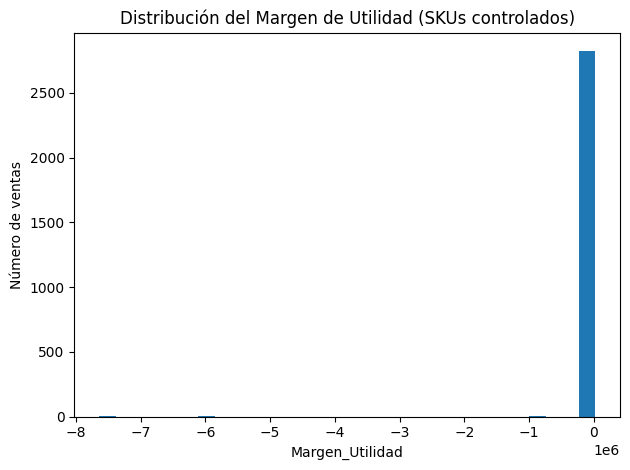

In [253]:
if "Margen_Utilidad" in controlados.columns:
    plt.figure()
    plt.hist(controlados["Margen_Utilidad"].dropna(), bins=30)
    plt.title("Distribución del Margen de Utilidad (SKUs controlados)")
    plt.xlabel("Margen_Utilidad")
    plt.ylabel("Número de ventas")
    plt.tight_layout()
    plt.show()



##### Ingreso por Categoría

¿De dónde viene el dinero?

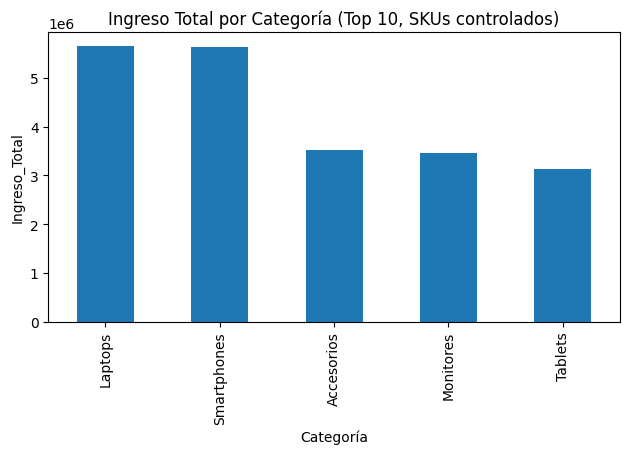

In [254]:
if "Categoria" in controlados.columns and "Ingreso_Total" in controlados.columns:
    top = (controlados.groupby("Categoria")["Ingreso_Total"]
           .sum()
           .sort_values(ascending=False)
           .head(10))

    plt.figure()
    top.plot(kind="bar")
    plt.title("Ingreso Total por Categoría (Top 10, SKUs controlados)")
    plt.xlabel("Categoría")
    plt.ylabel("Ingreso_Total")
    plt.tight_layout()
    plt.show()



##### Entregas tardías (proporción total)

¿Qué tan confiable es la logística?

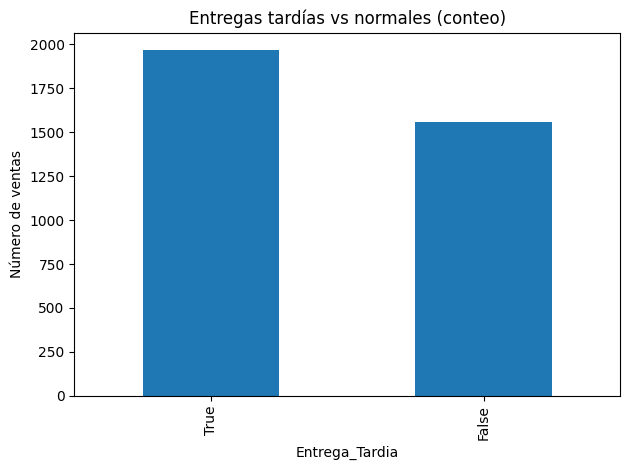

In [255]:
if "Entrega_Tardia" in df.columns:
    vc = df["Entrega_Tardia"].value_counts(dropna=False)

    plt.figure()
    vc.plot(kind="bar")
    plt.title("Entregas tardías vs normales (conteo)")
    plt.xlabel("Entrega_Tardia")
    plt.ylabel("Número de ventas")
    plt.tight_layout()
    plt.show()


#### Margen vs costo de envío (controlados)

¿El envío está comiéndose la rentabilidad?

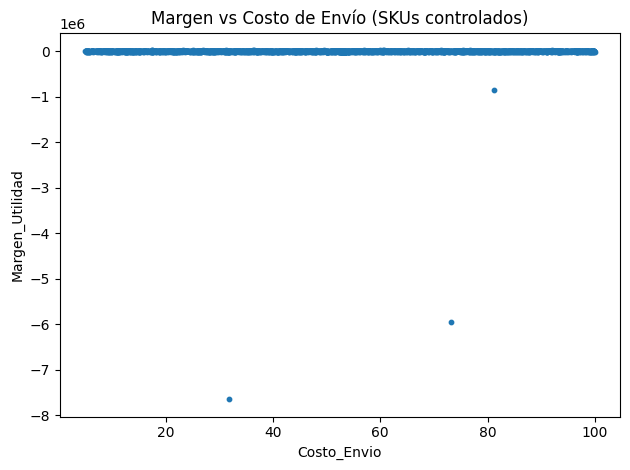

In [256]:
if {"Margen_Utilidad", "Costo_Envio"}.issubset(controlados.columns):
    plt.figure()
    plt.scatter(controlados["Costo_Envio"], controlados["Margen_Utilidad"], s=10)
    plt.title("Margen vs Costo de Envío (SKUs controlados)")
    plt.xlabel("Costo_Envio")
    plt.ylabel("Margen_Utilidad")
    plt.tight_layout()
    plt.show()


#### Margen % por canal (controlados)

¿Qué canal vende rentable?

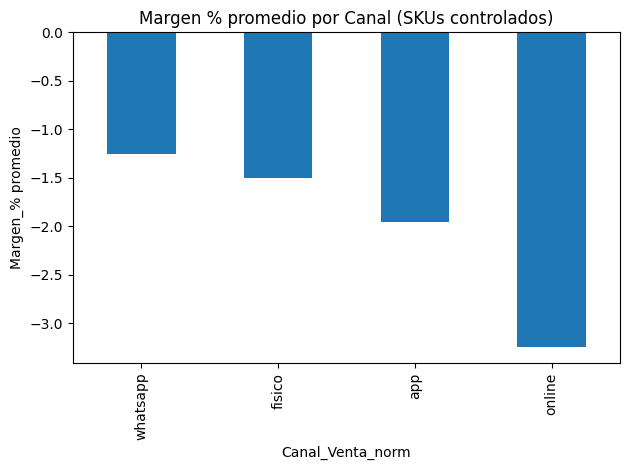

In [257]:
if {"Canal_Venta_norm", "Margen_%"}.issubset(controlados.columns):
    by = (controlados.groupby("Canal_Venta_norm")["Margen_%"]
          .mean()
          .sort_values(ascending=False))

    plt.figure()
    by.plot(kind="bar")
    plt.title("Margen % promedio por Canal (SKUs controlados)")
    plt.xlabel("Canal_Venta_norm")
    plt.ylabel("Margen_% promedio")
    plt.tight_layout()
    plt.show()


#### NPS vs entrega tardía (toda la operación o controlados)

¿Los retrasos bajan la satisfacción?

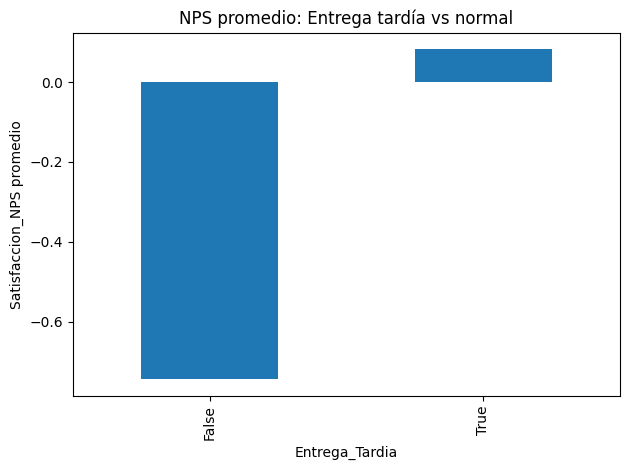

In [258]:
base = df.copy()

if {"Satisfaccion_NPS","Entrega_Tardia"}.issubset(base.columns):
    grp = base.groupby("Entrega_Tardia")["Satisfaccion_NPS"].mean()

    plt.figure()
    grp.plot(kind="bar")
    plt.title("NPS promedio: Entrega tardía vs normal")
    plt.xlabel("Entrega_Tardia")
    plt.ylabel("Satisfaccion_NPS promedio")
    plt.tight_layout()
    plt.show()


#### Riesgo por categoría (controlados)
¿Qué categorías concentran riesgo?

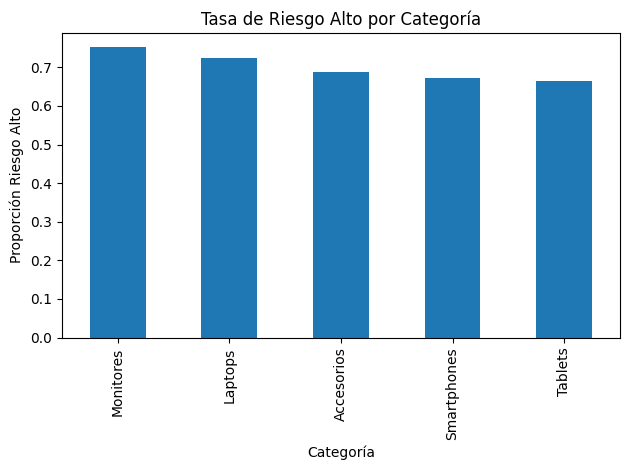

In [259]:
if {"Categoria","Riesgo_Operacion"}.issubset(controlados.columns):
    vol = (controlados["Categoria"].value_counts().head(10).index)
    sub = controlados[controlados["Categoria"].isin(vol)].copy()

    risk_rate = (sub.assign(Riesgo_Alto=sub["Riesgo_Operacion"].eq("Alto"))
                   .groupby("Categoria")["Riesgo_Alto"].mean()
                   .sort_values(ascending=False))

    plt.figure()
    risk_rate.plot(kind="bar")
    plt.title("Tasa de Riesgo Alto por Categoría")
    plt.xlabel("Categoría")
    plt.ylabel("Proporción Riesgo Alto")
    plt.tight_layout()
    plt.show()


#### SKU fantasma: cuantificar el negocio fuera de control


SKU Fantasma: auditoría

Ingreso por canal (controlado vs fantasma):
es_fantasma            False       True 
Canal_Venta_norm                        
fisico            5229610.50  1459003.99
whatsapp          5487436.86  1417145.27
online            5291500.09  1267871.82
app               5429329.16  1176412.74


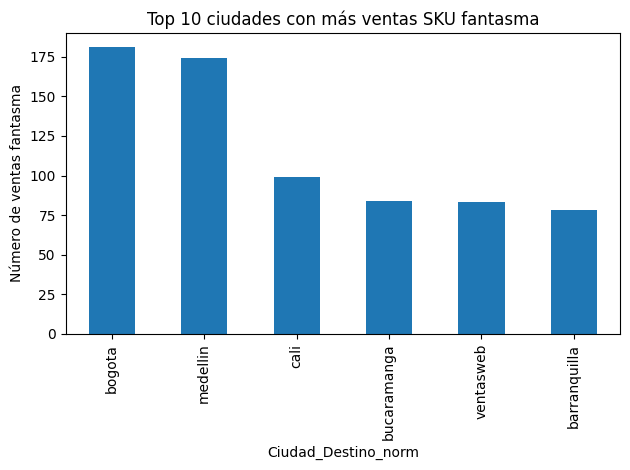

In [260]:
print("\nSKU Fantasma: auditoría")

# Ingreso fantasma por canal
if {"Canal_Venta_norm","Ingreso_Total"}.issubset(df.columns):
    tab = (df.assign(es_fantasma=df["SKU_Fantasma"])
             .groupby(["Canal_Venta_norm","es_fantasma"])["Ingreso_Total"]
             .sum()
             .unstack(fill_value=0))

    print("\nIngreso por canal (controlado vs fantasma):")
    print(tab.sort_values(by=True if True in tab.columns else tab.columns[-1], ascending=False).head(10))

# Conteo fantasma por ciudad (Top 10)
if "Ciudad_Destino_norm" in df.columns:
    top_c = (df[df["SKU_Fantasma"] == True]["Ciudad_Destino_norm"]
             .value_counts()
             .head(10))

    plt.figure()
    top_c.plot(kind="bar")
    plt.title("Top 10 ciudades con más ventas SKU fantasma")
    plt.xlabel("Ciudad_Destino_norm")
    plt.ylabel("Número de ventas fantasma")
    plt.tight_layout()
    plt.show()


#### Fuga de Capital y Rentabilidad

In [261]:
base = controlados.dropna(subset=["SKU_ID","Margen_Utilidad","Ingreso_Total","Cantidad_Vendida","Canal_Venta_norm"]).copy()

sku_kpi = (base.groupby("SKU_ID", as_index=False)
           .agg(
               Ventas=("Transaccion_ID","count"),
               Unidades=("Cantidad_Vendida","sum"),
               Ingreso=("Ingreso_Total","sum"),
               Margen=("Margen_Utilidad","sum")
           ))
sku_kpi["Margen_%"] = np.where(sku_kpi["Ingreso"]>0, sku_kpi["Margen"]/sku_kpi["Ingreso"], np.nan)

neg_skus = sku_kpi[sku_kpi["Margen"] < 0].sort_values("Margen")  # más pérdida primero

print("\nKUs con margen total negativo (Top 20)")
print(neg_skus.head(20))

# Peso del problema
ingreso_ctrl = base["Ingreso_Total"].sum()
ingreso_en_perdida = base.loc[base["Margen_Utilidad"] < 0, "Ingreso_Total"].sum()
perdida_total = base.loc[base["Margen_Utilidad"] < 0, "Margen_Utilidad"].sum()

print("\nIngreso controlado:", round(ingreso_ctrl,2))
print("Ingreso en ventas con margen negativo:", round(ingreso_en_perdida,2),
      f"({100*ingreso_en_perdida/ingreso_ctrl:.2f}%)")
print("Pérdida total (margen negativo acumulado):", round(perdida_total,2))



KUs con margen total negativo (Top 20)
         SKU_ID  Ventas  Unidades   Ingreso        Margen    Margen_%
322   PROD-1500       3      17.0  17391.55 -1.443279e+07 -829.873974
1627  PROD-3432       5      51.0  41531.82 -3.428945e+04   -0.825619
1065  PROD-2609       5      49.0  24130.38 -3.350950e+04   -1.388685
603   PROD-1903       4      37.0   9459.87 -2.870194e+04   -3.034073
923   PROD-2383       3      29.0  13809.34 -2.654071e+04   -1.921939
1233  PROD-2858       2      20.0   1799.17 -2.336466e+04  -12.986355
710   PROD-2076       2      17.0   1922.60 -2.335755e+04  -12.148939
1071  PROD-2617       4      47.0  32198.53 -2.227837e+04   -0.691906
1292  PROD-2936       2      22.0   8425.56 -2.186108e+04   -2.594614
819   PROD-2233       4      32.0  15209.60 -2.184002e+04   -1.435936
1407  PROD-3110       2      25.0   9828.57 -2.034494e+04   -2.069980
1274  PROD-2908       3      33.0  28384.36 -1.995566e+04   -0.703051
903   PROD-2353       2      26.0   9715.03 -1.907

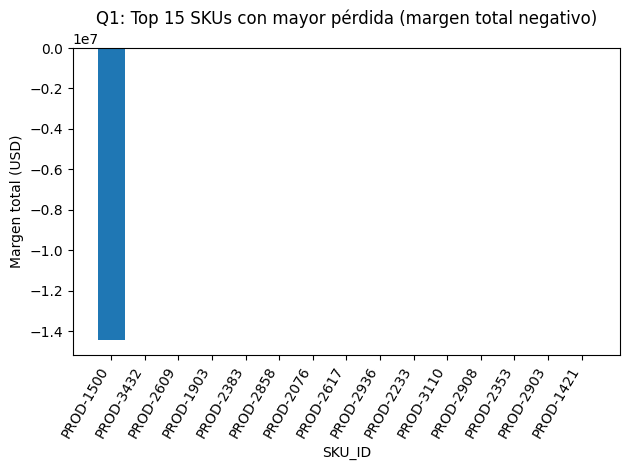

In [262]:
base = controlados.dropna(subset=["SKU_ID","Margen_Utilidad","Ingreso_Total","Cantidad_Vendida","Canal_Venta_norm"]).copy()

sku_kpi = (base.groupby("SKU_ID", as_index=False)
           .agg(
               Ventas=("Transaccion_ID","count"),
               Unidades=("Cantidad_Vendida","sum"),
               Ingreso=("Ingreso_Total","sum"),
               Margen=("Margen_Utilidad","sum")
           ))
sku_kpi = sku_kpi[sku_kpi["Margen"] < 0].sort_values("Margen").head(15)

plt.figure()
plt.bar(sku_kpi["SKU_ID"].astype(str), sku_kpi["Margen"])
plt.title("Q1: Top 15 SKUs con mayor pérdida (margen total negativo)")
plt.xlabel("SKU_ID")
plt.ylabel("Margen total (USD)")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()


¿Online es crítico? % del ingreso en pérdidas por canal

In [274]:
by_channel = (base.assign(Perdida=(base["Margen_Utilidad"] < 0))
              .groupby("Canal_Venta_norm", as_index=False)
              .agg(
                  Ventas=("Transaccion_ID","count"),
                  Ingreso=("Ingreso_Total","sum"),
                  Margen=("Margen_Utilidad","sum"),
                  Tasa_Perdida=("Perdida","mean")
              ))
by_channel["%Ingreso_en_Perdida"] = np.where(
    by_channel["Ingreso"]>0,
    (base[base["Margen_Utilidad"]<0].groupby("Canal_Venta_norm")["Ingreso_Total"].sum()
      .reindex(by_channel["Canal_Venta_norm"]).values) / by_channel["Ingreso"],
    np.nan
)

by_channel = by_channel.sort_values("%Ingreso_en_Perdida", ascending=False)

print("\nQ1: Pérdidas por canal")
print(by_channel.round(4))



Q1: Pérdidas por canal
  Canal_Venta_norm  Ventas     Ingreso        Margen  Tasa_Perdida  \
1           fisico     705  5229610.50  1.017864e+06        0.4199   
3         whatsapp     731  5487436.86  1.307322e+06        0.3912   
0              app     704  5429329.16 -4.584215e+06        0.3480   
2           online     686  5291500.09 -7.094959e+06        0.3819   

   %Ingreso_en_Perdida  
1               0.2161  
3               0.1910  
0               0.1848  
2               0.1812  


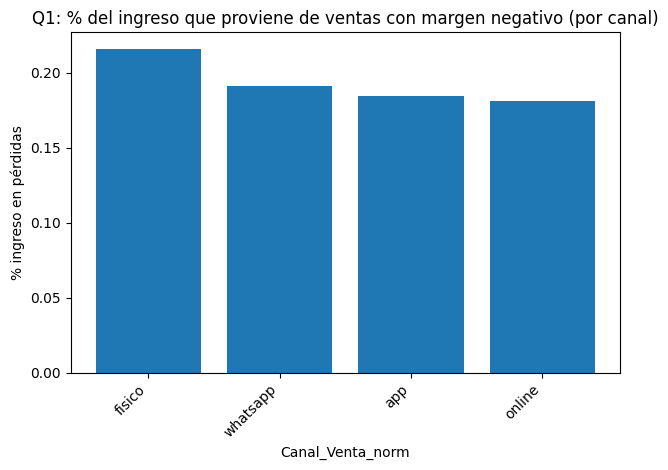

In [263]:
tmp = base.copy()
tmp["Perdida"] = tmp["Margen_Utilidad"] < 0

by_channel = (tmp.groupby("Canal_Venta_norm", as_index=False)
              .agg(
                  Ingreso_Total=("Ingreso_Total","sum"),
                  Ingreso_en_Perdida=("Ingreso_Total", lambda s: s[tmp.loc[s.index,"Perdida"]].sum())
              ))
by_channel["%Ingreso_en_Perdida"] = np.where(
    by_channel["Ingreso_Total"]>0,
    by_channel["Ingreso_en_Perdida"]/by_channel["Ingreso_Total"],
    np.nan
)
by_channel = by_channel.sort_values("%Ingreso_en_Perdida", ascending=False)

plt.figure()
plt.bar(by_channel["Canal_Venta_norm"].astype(str), by_channel["%Ingreso_en_Perdida"])
plt.title("Q1: % del ingreso que proviene de ventas con margen negativo (por canal)")
plt.xlabel("Canal_Venta_norm")
plt.ylabel("% ingreso en pérdidas")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


¿Pérdida “aceptable por volumen”? Ingreso vs Margen por SKU (Top por ingreso)

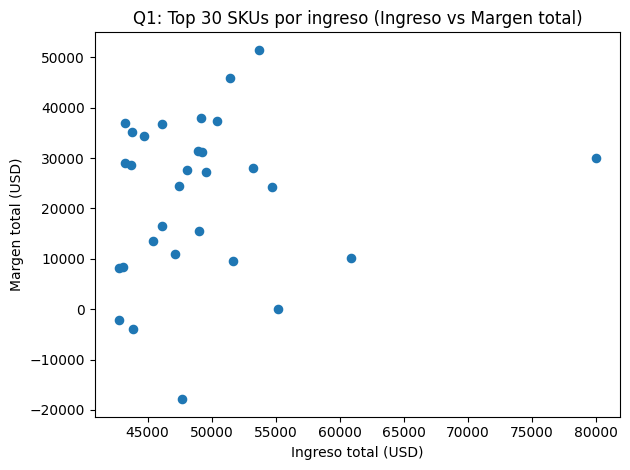

In [264]:
sku_full = (base.groupby("SKU_ID", as_index=False)
            .agg(Ingreso=("Ingreso_Total","sum"), Margen=("Margen_Utilidad","sum")))
top_ing = sku_full.sort_values("Ingreso", ascending=False).head(30)

plt.figure()
plt.scatter(top_ing["Ingreso"], top_ing["Margen"], s=35)
plt.title("Q1: Top 30 SKUs por ingreso (Ingreso vs Margen total)")
plt.xlabel("Ingreso total (USD)")
plt.ylabel("Margen total (USD)")
plt.tight_layout()
plt.show()


#### Crisis Logística y Cuellos de Botella

Top ciudades por correlación (Tiempo Entrega → NPS bajo)

In [276]:
log_base = df.dropna(subset=["Tiempo_Entrega_Real","Satisfaccion_NPS","Ciudad_Destino_norm"]).copy()
log_base["NPS_bajo"] = (log_base["Satisfaccion_NPS"] <= 0).astype(int)

def corr_time_vs_npslow(g):
    # correlación entre tiempo y NPS_bajo (0/1)
    return g["Tiempo_Entrega_Real"].corr(g["NPS_bajo"])

city_stats = (log_base.groupby("Ciudad_Destino_norm")
              .agg(
                  n=("Transaccion_ID","count"),
                  tiempo_prom=("Tiempo_Entrega_Real","mean"),
                  tasa_nps_bajo=("NPS_bajo","mean")
              ))
city_stats["corr_tiempo_vs_nps_bajo"] = log_base.groupby("Ciudad_Destino_norm").apply(corr_time_vs_npslow)

# Evitar conclusiones por poca data
city_stats = city_stats[city_stats["n"] >= 50].sort_values("corr_tiempo_vs_nps_bajo", ascending=False)

print("\nQ2: Top ciudades por correlación (n>=50)")
print(city_stats.head(15).round(4))



Q2: Top ciudades por correlación (n>=50)
                       n  tiempo_prom  tasa_nps_bajo  corr_tiempo_vs_nps_bajo
Ciudad_Destino_norm                                                          
cali                 443      13.7025         0.4853                   0.0413
bogota               911      14.9031         0.4797                   0.0228
ventasweb            482      15.6033         0.5311                  -0.0031
bucaramanga          415      15.2289         0.4988                  -0.0094
barranquilla         421      15.4252         0.5297                  -0.0204
medellin             853      15.1168         0.5135                  -0.0225


/tmp/ipython-input-3134971888.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_stats["corr_tiempo_vs_nps_bajo"] = log_base.groupby("Ciudad_Destino_norm").apply(corr_time_vs_npslow)


/tmp/ipython-input-1841424333.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  city_stats["corr_tiempo_vs_nps_bajo"] = log_base.groupby("Ciudad_Destino_norm").apply(corr_time_vs_npslow)


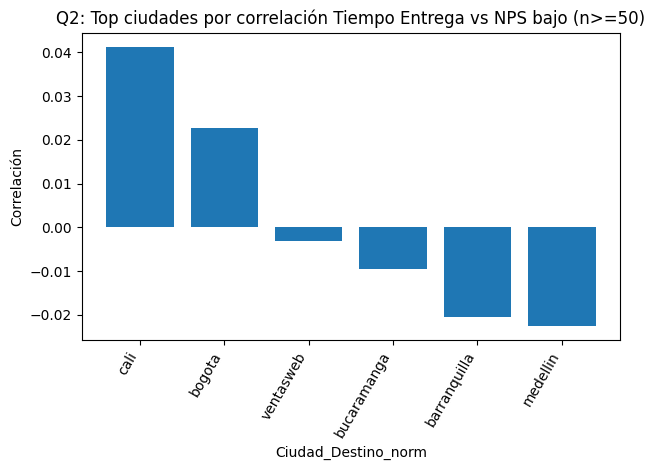

In [265]:
log_base = df.dropna(subset=["Tiempo_Entrega_Real","Satisfaccion_NPS","Ciudad_Destino_norm"]).copy()
log_base["NPS_bajo"] = (log_base["Satisfaccion_NPS"] <= 0).astype(int)

def corr_time_vs_npslow(g):
    return g["Tiempo_Entrega_Real"].corr(g["NPS_bajo"])

city_stats = (log_base.groupby("Ciudad_Destino_norm")
              .agg(n=("Transaccion_ID","count"),
                   tasa_nps_bajo=("NPS_bajo","mean"),
                   tiempo_prom=("Tiempo_Entrega_Real","mean")))
city_stats["corr_tiempo_vs_nps_bajo"] = log_base.groupby("Ciudad_Destino_norm").apply(corr_time_vs_npslow)

city_stats = city_stats[city_stats["n"] >= 50].sort_values("corr_tiempo_vs_nps_bajo", ascending=False).head(12)

plt.figure()
plt.bar(city_stats.index.astype(str), city_stats["corr_tiempo_vs_nps_bajo"])
plt.title("Q2: Top ciudades por correlación Tiempo Entrega vs NPS bajo (n>=50)")
plt.xlabel("Ciudad_Destino_norm")
plt.ylabel("Correlación")
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()


Top bodegas por correlación (Tiempo Entrega → NPS bajo)

In [277]:
bod_base = controlados.dropna(subset=["Tiempo_Entrega_Real","Satisfaccion_NPS","Bodega_Origen"]).copy()
bod_base["NPS_bajo"] = (bod_base["Satisfaccion_NPS"] <= 0).astype(int)

bod_stats = (bod_base.groupby("Bodega_Origen")
             .agg(
                 n=("Transaccion_ID","count"),
                 tiempo_prom=("Tiempo_Entrega_Real","mean"),
                 tasa_nps_bajo=("NPS_bajo","mean")
             ))
bod_stats["corr_tiempo_vs_nps_bajo"] = bod_base.groupby("Bodega_Origen").apply(corr_time_vs_npslow)
bod_stats = bod_stats[bod_stats["n"] >= 50].sort_values("corr_tiempo_vs_nps_bajo", ascending=False)

print("\nQ2: Top bodegas por correlación (n>=50, controlados)")
print(bod_stats.head(10).round(4))



Q2: Top bodegas por correlación (n>=50, controlados)
                 n  tiempo_prom  tasa_nps_bajo  corr_tiempo_vs_nps_bajo
Bodega_Origen                                                          
Occidente      456      14.4851         0.5373                   0.0233
Zona Franca    456      15.0607         0.5110                   0.0151
Norte          945      14.9837         0.5048                   0.0066
Externa        470      15.2532         0.4681                  -0.0038
Sur            499      15.0178         0.5030                  -0.0268


/tmp/ipython-input-2516239981.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bod_stats["corr_tiempo_vs_nps_bajo"] = bod_base.groupby("Bodega_Origen").apply(corr_time_vs_npslow)


/tmp/ipython-input-4063429023.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bod_stats["corr_tiempo_vs_nps_bajo"] = bod_base.groupby("Bodega_Origen").apply(corr_time_vs_npslow)


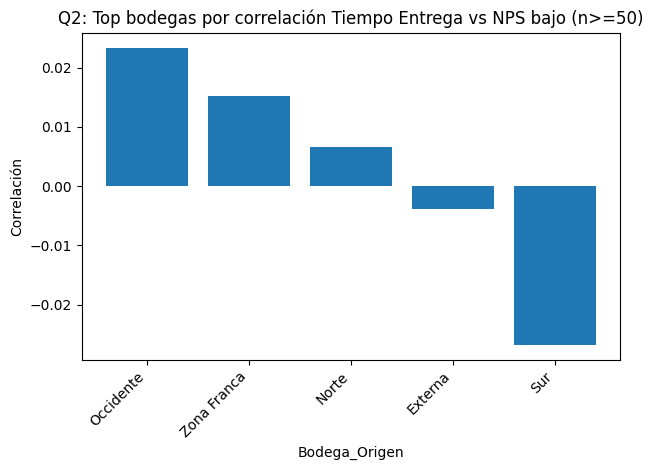

In [266]:
bod_base = controlados.dropna(subset=["Tiempo_Entrega_Real","Satisfaccion_NPS","Bodega_Origen"]).copy()
bod_base["NPS_bajo"] = (bod_base["Satisfaccion_NPS"] <= 0).astype(int)

bod_stats = (bod_base.groupby("Bodega_Origen")
             .agg(n=("Transaccion_ID","count"),
                  tasa_nps_bajo=("NPS_bajo","mean"),
                  tiempo_prom=("Tiempo_Entrega_Real","mean")))
bod_stats["corr_tiempo_vs_nps_bajo"] = bod_base.groupby("Bodega_Origen").apply(corr_time_vs_npslow)

bod_stats = bod_stats[bod_stats["n"] >= 50].sort_values("corr_tiempo_vs_nps_bajo", ascending=False).head(10)

plt.figure()
plt.bar(bod_stats.index.astype(str), bod_stats["corr_tiempo_vs_nps_bajo"])
plt.title("Q2: Top bodegas por correlación Tiempo Entrega vs NPS bajo (n>=50)")
plt.xlabel("Bodega_Origen")
plt.ylabel("Correlación")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Evidencia visual para la “zona crítica” (scatter)

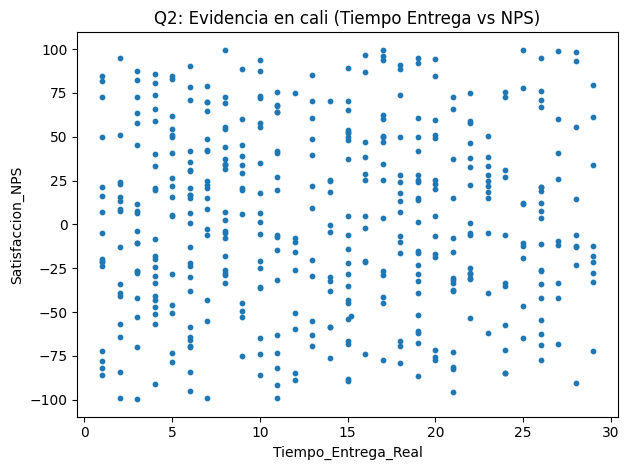

In [267]:
crit = city_stats.copy()
crit["score"] = crit["corr_tiempo_vs_nps_bajo"].fillna(0) * crit["tasa_nps_bajo"].fillna(0)
worst_city = crit.sort_values("score", ascending=False).index[0]

sub = log_base[log_base["Ciudad_Destino_norm"] == worst_city]

plt.figure()
plt.scatter(sub["Tiempo_Entrega_Real"], sub["Satisfaccion_NPS"], s=10)
plt.title(f"Q2: Evidencia en {worst_city} (Tiempo Entrega vs NPS)")
plt.xlabel("Tiempo_Entrega_Real")
plt.ylabel("Satisfaccion_NPS")
plt.tight_layout()
plt.show()


#### Análisis de la Venta Invisible

¿Cuánto ingreso está en riesgo por SKUs fuera del inventario?

Comparación directa de ingresos (controlado vs fantasma)


== Q3: Venta Invisible (SKU fantasma) ==
Ingreso total: 26758310.43
Ingreso SKU fantasma: 5320433.82
% del ingreso total en riesgo (sin control de inventario): 19.88 %


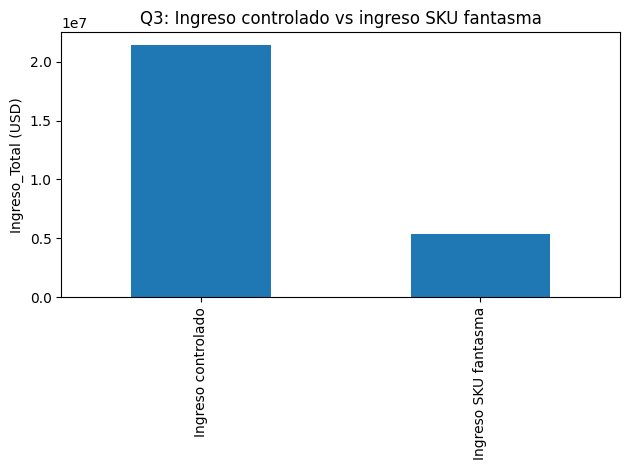

In [279]:
total_ingreso = df["Ingreso_Total"].sum()
ingreso_fantasma = fantasmas["Ingreso_Total"].sum()
pct_riesgo = ingreso_fantasma / total_ingreso if total_ingreso > 0 else np.nan

print("\nQ3: Venta Invisible (SKU fantasma)")
print("Ingreso total:", round(total_ingreso, 2))
print("Ingreso SKU fantasma:", round(ingreso_fantasma, 2))
print("% del ingreso total en riesgo (sin control de inventario):", round(100*pct_riesgo, 2), "%")

comp = pd.Series({
    "Ingreso controlado": controlados["Ingreso_Total"].sum(),
    "Ingreso SKU fantasma": ingreso_fantasma
})

plt.figure()
comp.plot(kind="bar")
plt.title("Q3: Ingreso controlado vs ingreso SKU fantasma")
plt.xlabel("")
plt.ylabel("Ingreso_Total (USD)")
plt.tight_layout()
plt.show()


#### Diagnóstico de Fidelidad

categorías con stock alto pero sentimiento negativo. ¿calidad o sobrecosto?

In [280]:
fid = controlados.dropna(subset=["Categoria","Stock_Actual","Satisfaccion_NPS","Rating_Producto","Rating_Logistica",
                                 "Costo_Envio","Margen_Utilidad","Ingreso_Total"]).copy()

cat = (fid.groupby("Categoria", as_index=False)
       .agg(
           ventas=("Transaccion_ID","count"),
           stock_prom=("Stock_Actual","mean"),
           nps_prom=("Satisfaccion_NPS","mean"),
           rating_prod_prom=("Rating_Producto","mean"),
           rating_log_prom=("Rating_Logistica","mean"),
           envio_prom=("Costo_Envio","mean"),
           margen_prom=("Margen_Utilidad","mean"),
           ingreso=("Ingreso_Total","sum")
       ))

# Umbrales robustos (percentiles)
stock_p75 = cat["stock_prom"].quantile(0.75)
nps_p25 = cat["nps_prom"].quantile(0.25)

paradoja = cat[(cat["stock_prom"] >= stock_p75) & (cat["nps_prom"] <= nps_p25)].copy()
paradoja = paradoja.sort_values("ventas", ascending=False)

print("\n== Q4: Paradoja (stock alto + NPS bajo) ==")
print("Umbral stock (p75):", round(stock_p75,2), "| Umbral NPS (p25):", round(nps_p25,2))
print(paradoja.head(15).round(4))

# Diagnóstico simple (texto) por categoría: calidad vs sobrecosto/servicio
def diagnostico(row):
    # Heurística clara y defendible:
    # - Calidad: rating producto bajo
    # - Servicio/logística: rating logística bajo
    # - Sobrecosto: margen promedio bajo y/o costo envío alto (relativo)
    if row["rating_prod_prom"] < 3.5:
        return "Probable calidad de producto"
    if row["rating_log_prom"] < 3.5:
        return "Probable problema logístico/servicio"
    if row["margen_prom"] < 0:
        return "Probable sobrecosto (margen negativo)"
    return "Revisar mezcla precio/costo"

if len(paradoja) > 0:
    paradoja["Diagnostico"] = paradoja.apply(diagnostico, axis=1)
    print("\nDiagnóstico sugerido (Top 10):")
    print(paradoja[["Categoria","ventas","stock_prom","nps_prom","rating_prod_prom","rating_log_prom","envio_prom","margen_prom","Diagnostico"]]
          .head(10).round(4))



== Q4: Paradoja (stock alto + NPS bajo) ==
Umbral stock (p75): 1012.02 | Umbral NPS (p25): -1.38
     Categoria  ventas  stock_prom  nps_prom  rating_prod_prom  \
3  Smartphones     762   1012.0249   -4.5141            2.9707   

   rating_log_prom  envio_prom  margen_prom     ingreso  
3           3.0658     52.6648  -17359.5442  5643526.88  

Diagnóstico sugerido (Top 10):
     Categoria  ventas  stock_prom  nps_prom  rating_prod_prom  \
3  Smartphones     762   1012.0249   -4.5141            2.9707   

   rating_log_prom  envio_prom  margen_prom                   Diagnostico  
3           3.0658     52.6648  -17359.5442  Probable calidad de producto  


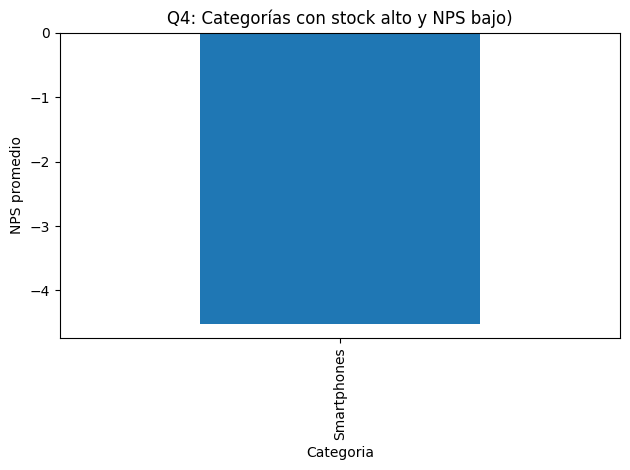

In [282]:
if len(paradoja) > 0:
    top = paradoja.head(10).set_index("Categoria")["nps_prom"]
    plt.figure()
    top.plot(kind="bar")
    plt.title("Q4: Categorías con stock alto y NPS bajo)")
    plt.xlabel("Categoria")
    plt.ylabel("NPS promedio")
    plt.tight_layout()
    plt.show()


Gráfico “cuadrante” Stock vs NPS por categoría

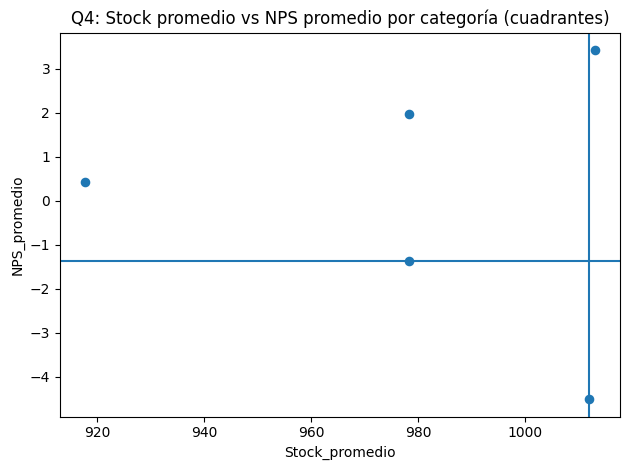

In [270]:
fid = controlados.dropna(subset=["Categoria","Stock_Actual","Satisfaccion_NPS","Rating_Producto","Rating_Logistica",
                                 "Costo_Envio","Margen_Utilidad"]).copy()

cat = (fid.groupby("Categoria", as_index=False)
       .agg(
           ventas=("Transaccion_ID","count"),
           stock_prom=("Stock_Actual","mean"),
           nps_prom=("Satisfaccion_NPS","mean"),
           rating_prod=("Rating_Producto","mean"),
           rating_log=("Rating_Logistica","mean"),
           envio_prom=("Costo_Envio","mean"),
           margen_prom=("Margen_Utilidad","mean")
       ))

# Usar percentiles como líneas de corte (robustos)
x_cut = cat["stock_prom"].quantile(0.75)
y_cut = cat["nps_prom"].quantile(0.25)

# Solo categorías con volumen razonable (evita ruido)
cat2 = cat[cat["ventas"] >= 30].copy()

plt.figure()
plt.scatter(cat2["stock_prom"], cat2["nps_prom"], s=35)
plt.axvline(x_cut)
plt.axhline(y_cut)
plt.title("Q4: Stock promedio vs NPS promedio por categoría (cuadrantes)")
plt.xlabel("Stock_promedio")
plt.ylabel("NPS_promedio")
plt.tight_layout()
plt.show()


Visual diagnóstico: “paradoja” con ratings y margen (barras)

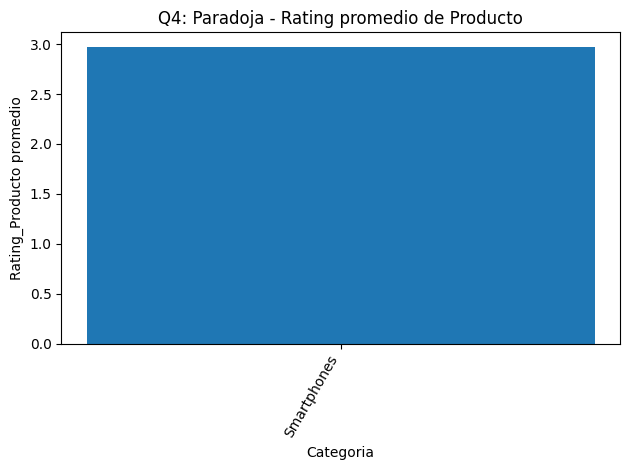

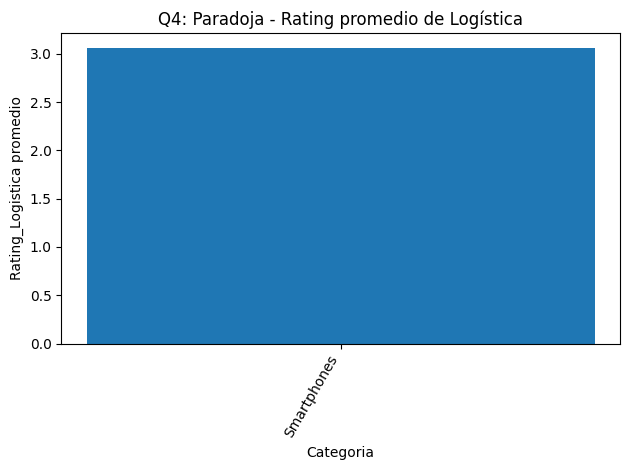

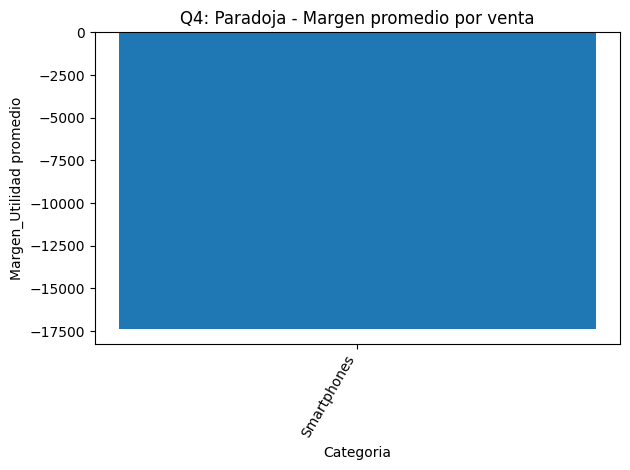

In [271]:
paradoja = cat2[(cat2["stock_prom"] >= x_cut) & (cat2["nps_prom"] <= y_cut)].copy()
paradoja = paradoja.sort_values("ventas", ascending=False).head(10)

# 1) Rating producto vs rating logística (comparación directa)
if len(paradoja) > 0:
    idx = paradoja["Categoria"].astype(str)

    plt.figure()
    plt.bar(idx, paradoja["rating_prod"])
    plt.title("Q4: Paradoja - Rating promedio de Producto")
    plt.xlabel("Categoria")
    plt.ylabel("Rating_Producto promedio")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.bar(idx, paradoja["rating_log"])
    plt.title("Q4: Paradoja - Rating promedio de Logística")
    plt.xlabel("Categoria")
    plt.ylabel("Rating_Logistica promedio")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()

    # 2) Margen promedio (si es muy negativo sugiere sobrecosto / pricing)
    plt.figure()
    plt.bar(idx, paradoja["margen_prom"])
    plt.title("Q4: Paradoja - Margen promedio por venta")
    plt.xlabel("Categoria")
    plt.ylabel("Margen_Utilidad promedio")
    plt.xticks(rotation=60, ha="right")
    plt.tight_layout()
    plt.show()


#### Storytelling de Riesgo Operativo

Historia principal: tasa de tickets por “edad” (bins) + volumen por bin

In [284]:
risk = controlados.dropna(subset=["Ultima_Revision_dt","Ticket_Indicador"]).copy()

# Fecha de referencia: última venta observada (más consistente con dataset histórico)
ref_date = df["Fecha_Venta_dt"].max()
if pd.isna(ref_date):
    ref_date = df["Ultima_Revision_dt"].max()

risk["Antiguedad_Revision_Dias"] = (ref_date - risk["Ultima_Revision_dt"]).dt.days
risk = risk[(risk["Antiguedad_Revision_Dias"].notna()) & (risk["Antiguedad_Revision_Dias"] >= 0)]

# Storytelling: bins fáciles de explicar
bins = [0, 30, 60, 90, 180, 365, 10_000]
labels = ["0-30", "31-60", "61-90", "91-180", "181-365", "365+"]

risk["Edad_Bin"] = pd.cut(risk["Antiguedad_Revision_Dias"], bins=bins, labels=labels, include_lowest=True)

bin_stats = (risk.groupby("Edad_Bin", as_index=False)
             .agg(
                 n=("Transaccion_ID","count"),
                 tasa_tickets=("Ticket_Indicador","mean")
             ))

print("\nQ5: Tasa de tickets por antigüedad de revisión")
print(bin_stats)

corr = risk["Antiguedad_Revision_Dias"].corr(risk["Ticket_Indicador"])
print("Correlación (edad revisión vs tickets):", round(corr, 4))



Q5: Tasa de tickets por antigüedad de revisión
  Edad_Bin     n  tasa_tickets
0     0-30   153      0.483660
1    31-60   120      0.616667
2    61-90   133      0.571429
3   91-180   332      0.578313
4  181-365   747      0.583668
5     365+  1341      0.557047
Correlación (edad revisión vs tickets): -0.0152


/tmp/ipython-input-1001786421.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = (risk.groupby("Edad_Bin", as_index=False)


/tmp/ipython-input-3693022634.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = (risk.groupby("Edad_Bin", as_index=False)


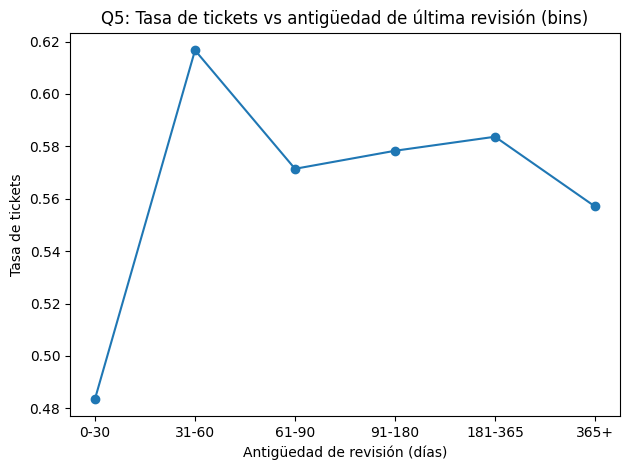

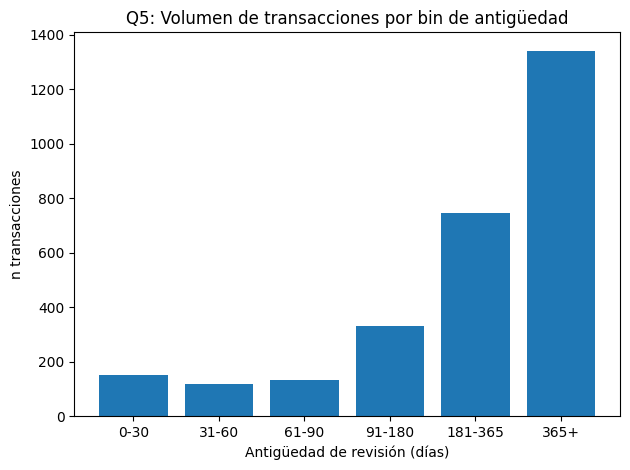

In [272]:
risk = controlados.dropna(subset=["Ultima_Revision_dt","Ticket_Indicador"]).copy()

# Fecha de referencia: última venta del dataset (consistente con datos históricos)
ref_date = df["Fecha_Venta_dt"].max()
if pd.isna(ref_date):
    ref_date = df["Ultima_Revision_dt"].max()

risk["Antiguedad_Revision_Dias"] = (ref_date - risk["Ultima_Revision_dt"]).dt.days
risk = risk[(risk["Antiguedad_Revision_Dias"].notna()) & (risk["Antiguedad_Revision_Dias"] >= 0)]

bins = [0, 30, 60, 90, 180, 365, 10_000]
labels = ["0-30", "31-60", "61-90", "91-180", "181-365", "365+"]

risk["Edad_Bin"] = pd.cut(risk["Antiguedad_Revision_Dias"], bins=bins, labels=labels, include_lowest=True)

bin_stats = (risk.groupby("Edad_Bin", as_index=False)
             .agg(
                 n=("Transaccion_ID","count"),
                 tasa_tickets=("Ticket_Indicador","mean")
             ))

plt.figure()
plt.plot(bin_stats["Edad_Bin"].astype(str), bin_stats["tasa_tickets"], marker="o")
plt.title("Q5: Tasa de tickets vs antigüedad de última revisión (bins)")
plt.xlabel("Antigüedad de revisión (días)")
plt.ylabel("Tasa de tickets")
plt.tight_layout()
plt.show()

plt.figure()
plt.bar(bin_stats["Edad_Bin"].astype(str), bin_stats["n"])
plt.title("Q5: Volumen de transacciones por bin de antigüedad")
plt.xlabel("Antigüedad de revisión (días)")
plt.ylabel("n transacciones")
plt.tight_layout()
plt.show()


Evidencia adicional (scatter) para ver si hay tendencia real

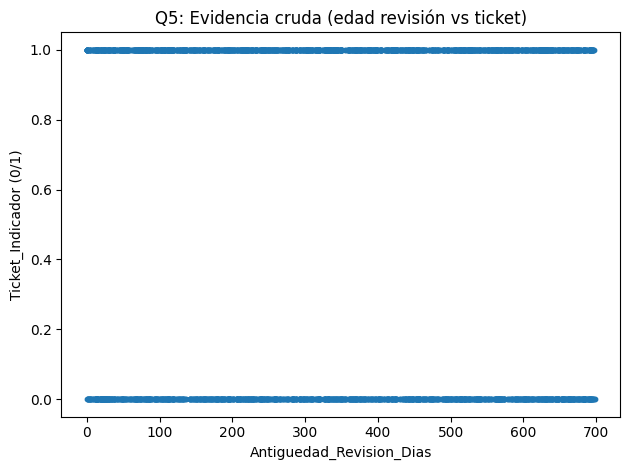

In [273]:
plt.figure()
plt.scatter(risk["Antiguedad_Revision_Dias"], risk["Ticket_Indicador"], s=10)
plt.title("Q5: Evidencia cruda (edad revisión vs ticket)")
plt.xlabel("Antiguedad_Revision_Dias")
plt.ylabel("Ticket_Indicador (0/1)")
plt.tight_layout()
plt.show()
